# **Credit Risk Modeling**

#### **Name: Bernardo Raimundo**

## **Table of Contents**

* [1. Introduction](#1)
* [2. Importing Libraries](#2)
* [3. Data Preparation](#3)
* [4. Dealing with potential Outliers](#4)
* [5. Encoding Variables](#5)
* [6. Machine Learning Pipeline](#6)
* [7. Stacking Approach](#7)

## **Introduction**

<a id="1"></a>

Credit risk scoring methods are widely used for evaluating potential loan applications in both financial and banking institutions. These procedures allow banks to describe the likelihood of a default over a particular time horizon. 

Financial institutions deploy models that consider the credit history of the borrowers and the inputs from their own economic stress scenarios to measure credit risk. Keen awareness is needed to identify, measure, monitor and control credit risk, guarantee sufficient capital against these risks and adequate compensation for the risks incurred.

When an institution receives a loan application, a decision regarding the approval of the loan has to be made considering the applicant’s profile. There are two types of risks assoiciated with this decision:

- If the applicant is likely to repay the loan, then not approving the loan results in a loss of business to an instituiton;

- If the applicant is not likely to repay the loan, i.e. he/she is likely to default, then approving the loan may lead to a financial.

The data for this specific scenario is provided by LendingClub, a P2P lending company that provides loans without the need of any financial intermdediation and/or collateral. Investors are responsible for their own decision on lending. Even though the company has fitter borrowers who meet the minimum requirements, there is still a huge risk of non-repayment. This is the problem that this project works on by making the prediction of loan status for these applicants.

The data contains information about past loan applicants and whether they ‘defaulted’ or not. 

The aim is to identify patterns, which may serve as key information to either deny a loan to an applicant, reduce the amount of loan or even lending at higher interest rate.

### **Main tasks of this research:**

- Make a preliminary statistical analysis of the credit dataset

- Develop a several models to predict the probability of default evaluating them using different performance metrics

- Utilize model combination (Stacking Generalization Approach) and compare it to the more traditional credit scoring methods

**This notebook covers the stacking ensemble approach**

## **Importing Libraries**

<a id="2"></a>

---

In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import collections
import category_encoders as ce
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, learning_curve, cross_validate
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn import set_config
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_curve, roc_auc_score, classification_report, confusion_matrix
from sklearn.pipeline import  Pipeline
from imblearn.pipeline import Pipeline as imb_pipeline
import warnings
import copy as cp
from collections.abc import Iterable
from more_itertools import powerset
from sklearn.ensemble import StackingClassifier

**Additional configuration features for easier vizualization**

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 0)
pd.options.mode.chained_assignment = None 
warnings.simplefilter(action="ignore", category=FutureWarning)

**Checking Working Directory**

In [3]:
os.getcwd() ### Check Working Directory

'C:\\Users\\raimu\\OneDrive - NOVAIMS\\Tese\\4. Tese\\Data\\Python File\\Dissertation Code'

**Importing Data**

In [4]:
df_train = pd.read_csv('1. dataset_for_feature_engeneering.csv')

In [5]:
df_train.drop(['Unnamed: 0'],1, inplace=True)

In [6]:
df_train.head()

,loan_amnt,term,int_rate,grade,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_pymnt_amnt,application_type,mort_acc,pub_rec_bankruptcies,fico_score
0,3600.0,36,13.99,C,MORTGAGE,55000.0,Not Verified,Fully Paid,debt_consolidation,PA,5.91,0.0,1.0,7.0,0.0,2765.0,29.7,13.0,122.67,Individual,1.0,0.0,562.0
1,24700.0,36,11.99,C,MORTGAGE,65000.0,Not Verified,Fully Paid,small_business,SD,16.06,1.0,4.0,22.0,0.0,21470.0,19.2,38.0,926.35,Individual,4.0,0.0,697.0
2,20000.0,60,10.78,B,MORTGAGE,63000.0,Not Verified,Fully Paid,home_improvement,IL,10.78,0.0,0.0,6.0,0.0,7869.0,56.2,18.0,15813.30,Joint App,5.0,0.0,702.0
3,10400.0,60,22.45,F,MORTGAGE,104433.0,Source Verified,Fully Paid,major_purchase,PA,25.37,1.0,3.0,12.0,0.0,21929.0,64.5,35.0,10128.96,Individual,6.0,0.0,702.0
4,11950.0,36,13.44,C,RENT,34000.0,Source Verified,Fully Paid,debt_consolidation,GA,10.20,0.0,0.0,5.0,0.0,8822.0,68.4,6.0,7653.56,Individual,0.0,0.0,757.0


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1345310 entries, 0 to 1345309
Data columns (total 23 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   loan_amnt             1345310 non-null  float64
 1   term                  1345310 non-null  int64  
 2   int_rate              1345310 non-null  float64
 3   grade                 1345310 non-null  object 
 4   home_ownership        1345310 non-null  object 
 5   annual_inc            1345310 non-null  float64
 6   verification_status   1345310 non-null  object 
 7   loan_status           1345310 non-null  object 
 8   purpose               1345310 non-null  object 
 9   addr_state            1345310 non-null  object 
 10  dti                   1344936 non-null  float64
 11  delinq_2yrs           1345310 non-null  float64
 12  inq_last_6mths        1345309 non-null  float64
 13  open_acc              1345310 non-null  float64
 14  pub_rec               1345310 non-

In [8]:
df_train.shape

(1345310, 23)

### **Data Preparation**


<a id="3"></a>

---

Now that we chose the potential variables for the modelling phase some more data preparation is required.

First check which variables have missing data:

In [9]:
def missing_data(df_train):
    total = df_train.isnull().sum()
    percent = (df_train.isnull().sum()/df_train.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in df_train.columns:
        dtype = str(df_train[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

missing_data(df_train)

,loan_amnt,term,int_rate,grade,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_pymnt_amnt,application_type,mort_acc,pub_rec_bankruptcies,fico_score
Total,0,0,0,0,0,0,0,0,0,0,374,0,1,0,0,0,857,0,0,0,47281,697,0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0278,0.0,0.000074,0.0,0.0,0.0,0.063703,0.0,0.0,0.0,3.514506,0.05181,0.0
Types,float64,int64,float64,object,object,float64,object,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64


**We still have some missing values but these represent less than 10% of the total data. These values will be median imputed.** 

**This step will be executed when we build the machine learning pipeline later on.**

### **Dealing with potential Outliers**


<a id="4"></a>

---

Outliers are values that fall of outside of the overall patern of a data set.

To deal with these outliers we decided to use the interquantile rule by:

- Calculate the Interquantile range (IQR) for the data

- Multiply the interquartile range (IQR) by 1.5 (a constant used to discern outliers).

- Add 1.5 x (IQR) to the third quartile. Any number greater than this is a suspected outlier.
 
- Subtract 1.5 x (IQR) from the first quartile. Any number less than this is a suspected outlier.

Outlier Removal Tradeoff:

We have to be careful as to how far do we want the threshold for removing outliers. We determine the threshold by multiplying a number (ex: 1.5) by the (Interquartile Range). The higher this threshold is, the less outliers will detect (multiplying by a higher number ex: 3), and the lower this threshold is the more outliers it will detect.

The Tradeoff: The lower the threshold the more outliers it will remove however, we want to focus more on "extreme outliers" rather than just outliers. Why? because we might run the risk of information loss which will cause our models to have a lower accuracy. 

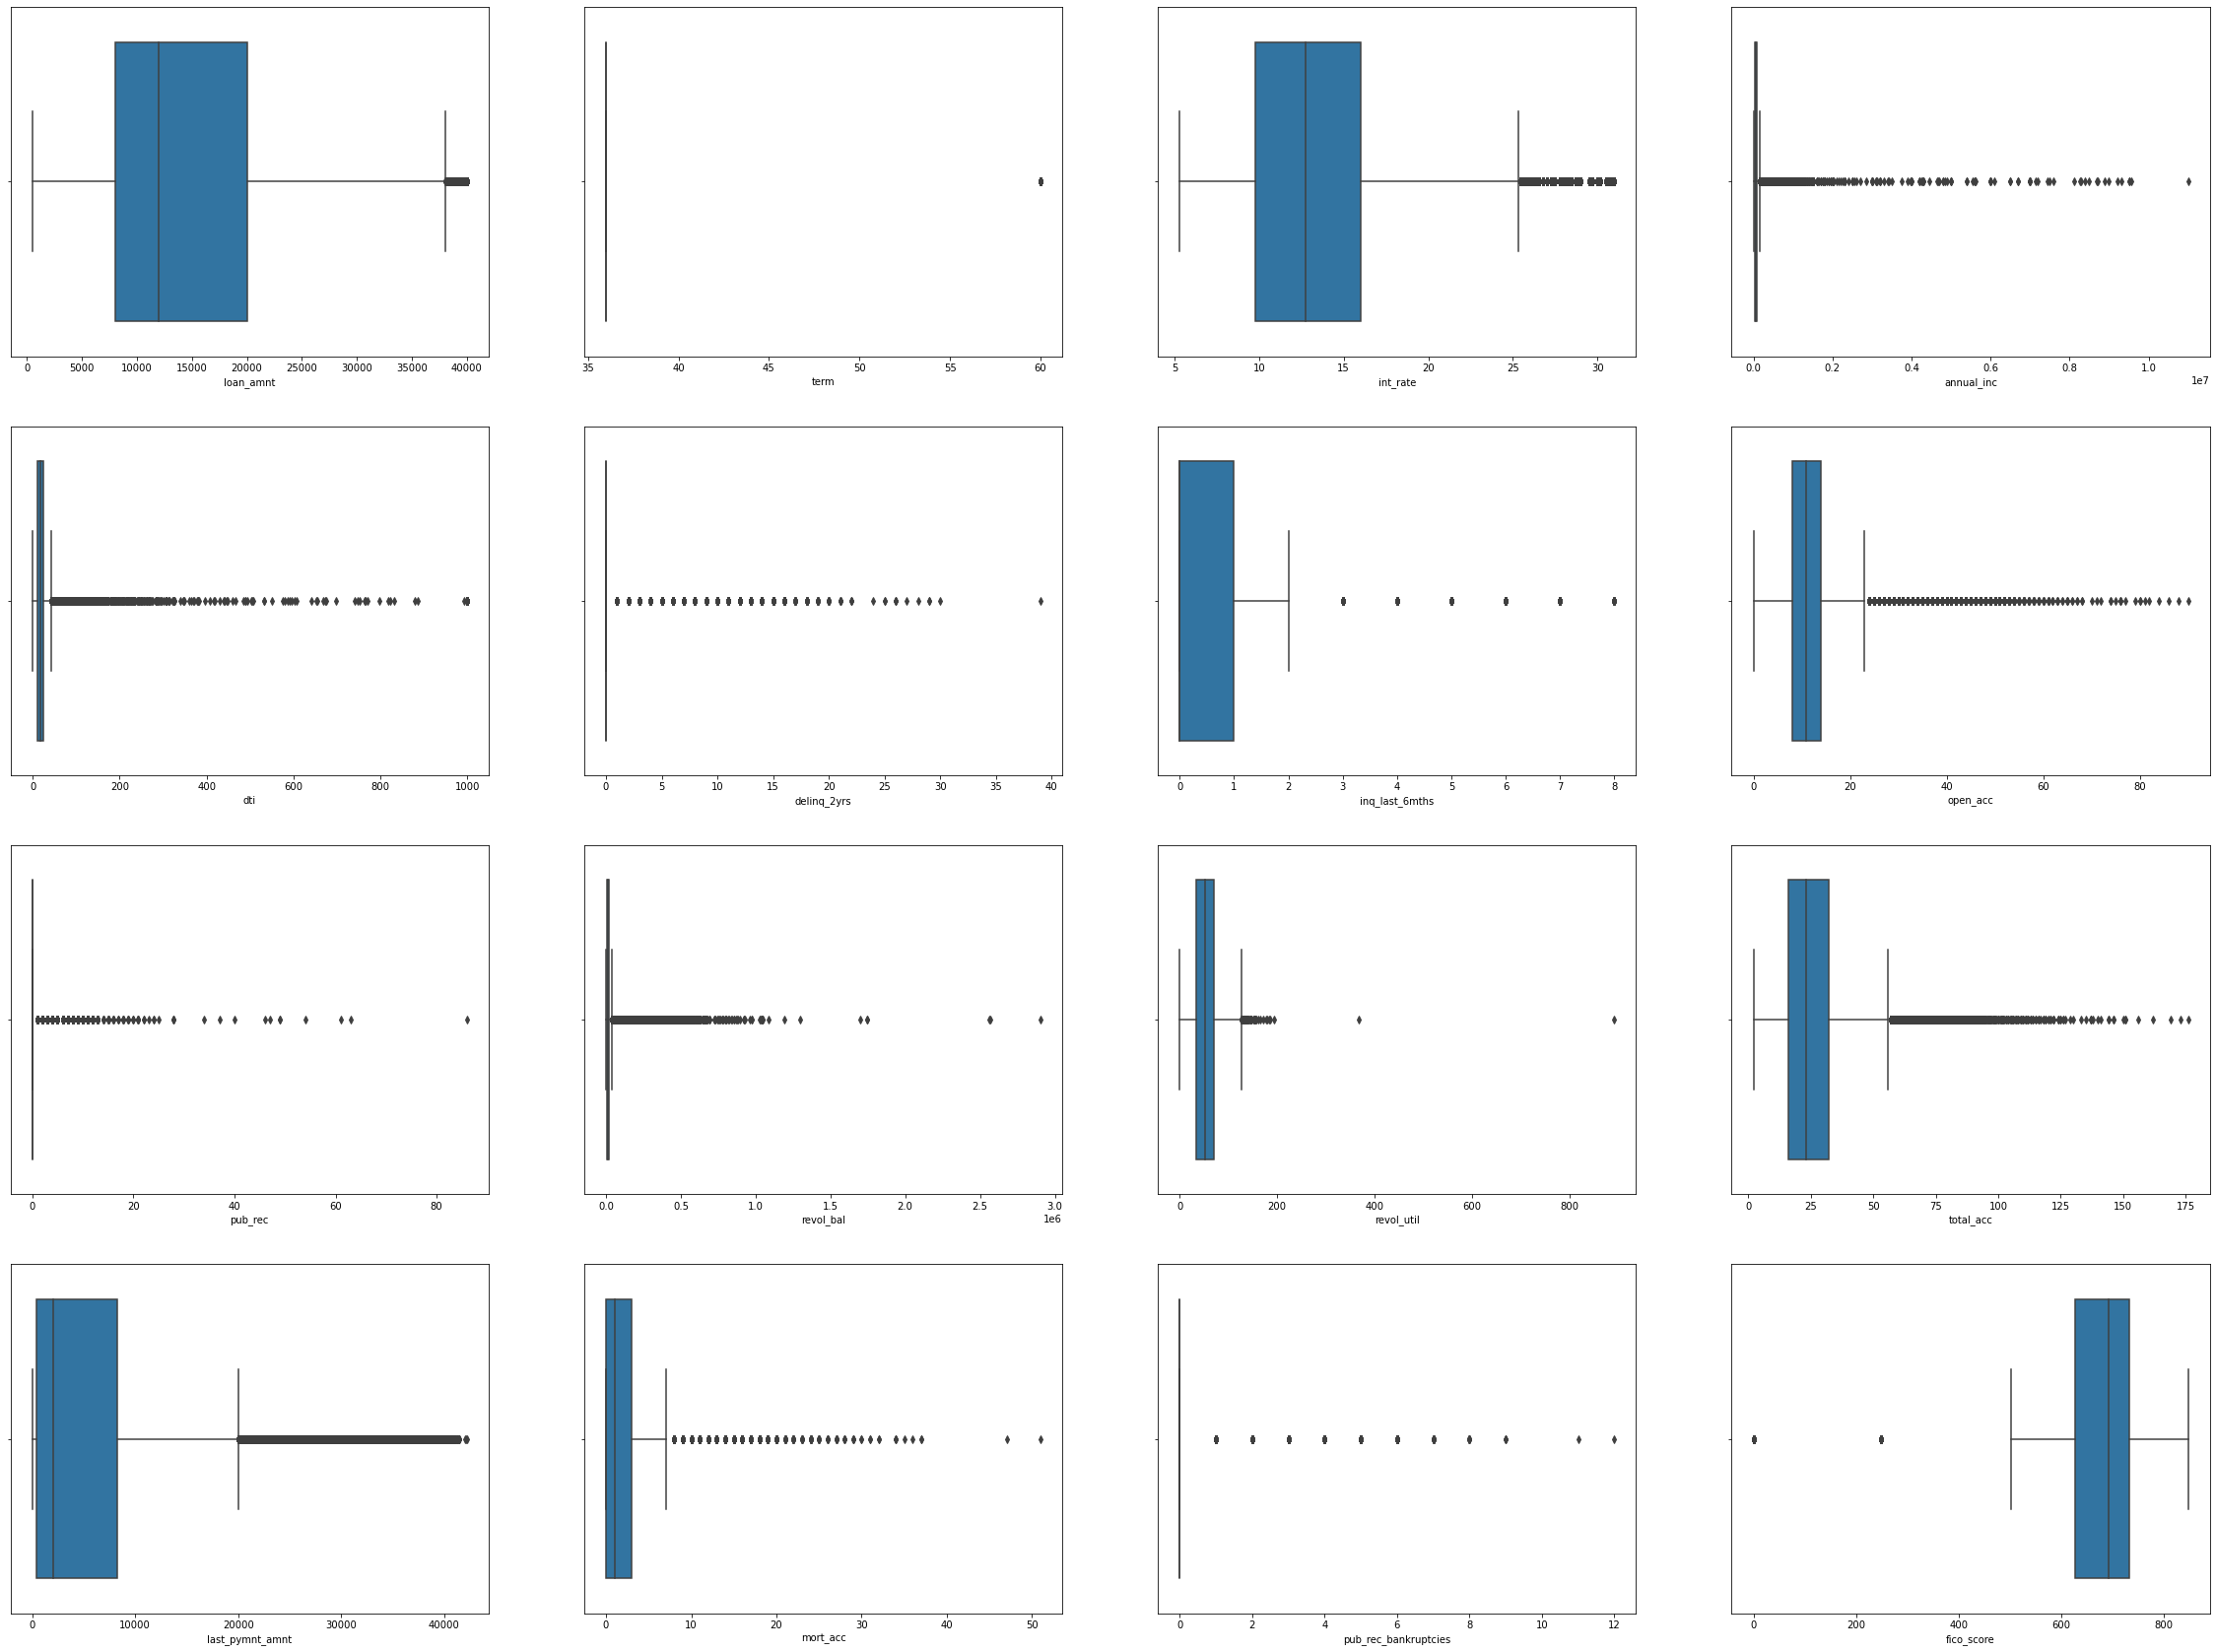

In [10]:
numerical = df_train.select_dtypes(include=[np.number]).columns.tolist()

fig, ax = plt.subplots(4, 4, figsize=(40, 30))

for var, subplot in zip(df_train[numerical], ax.flatten()):
    
    sns.boxplot(df_train[var], ax=subplot)

Outliers are unusual values in a datset, and they can distort statistical analyses and violate their assumptions. 

Analysts / Data Scientits need to confront outliers and be forced to make decisions about what to do with them. Given the problems they can cause, you might think that it’s best to remove them from your data. But, that’s not always the case. We should only remove an outlier if we are able to justify its exclusion. 

As mentioned in the first notebook both annual income and dti are variables that present rather extreme outliers. The removal of these outliers goes as follows:

- Annual income: Values above 1000000 were dropped
- Dti: Values above 60 were dropped
- Revol_Bal: Values above 1000000 were dropped
- Fico_score: Values bellow 249.5 were dropped

In [11]:
df_train1 = df_train[df_train['annual_inc'] > 1000000]

In [12]:
df_train1.shape

(290, 23)

In [13]:
df_train1.head()

,loan_amnt,term,int_rate,grade,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_pymnt_amnt,application_type,mort_acc,pub_rec_bankruptcies,fico_score
6219,16000.0,36,5.32,A,RENT,1400000.0,Source Verified,Fully Paid,debt_consolidation,IL,0.07,0.0,0.0,10.0,0.0,3141.0,6.5,22.0,5027.63,Individual,2.0,0.0,802.0
6460,1225.0,36,11.99,C,RENT,3964280.0,Source Verified,Fully Paid,other,NY,0.05,0.0,0.0,5.0,0.0,1208.0,6.7,8.0,1131.00,Individual,0.0,0.0,687.0
9270,35000.0,36,11.22,B,MORTGAGE,2300000.0,Verified,Fully Paid,home_improvement,IL,2.39,0.0,0.0,8.0,0.0,41510.0,97.4,39.0,34725.96,Individual,4.0,0.0,712.0
16977,8000.0,36,7.89,A,MORTGAGE,1248000.0,Source Verified,Fully Paid,home_improvement,CA,1.30,1.0,1.0,17.0,1.0,6305.0,29.3,32.0,6247.85,Individual,3.0,0.0,597.0
19486,35000.0,36,13.67,C,MORTGAGE,2500000.0,Source Verified,Fully Paid,debt_consolidation,AZ,1.31,0.0,1.0,12.0,0.0,208165.0,44.6,32.0,1190.40,Individual,4.0,0.0,747.0


In [14]:
df_train2 = df_train1[df_train1['dti'] > 60]

In [15]:
df_train2.shape

(0, 23)

In [16]:
df_train4 = df_train[df_train['revol_bal'] > 1000000]

In [17]:
df_train4.shape

(15, 23)

In [18]:
df_train5 = df_train1[df_train1['fico_score'] <= 0]

In [19]:
df_train5.shape

(0, 23)

In [20]:
df_train1 = df_train[df_train['annual_inc'] <= 1000000]

df_train2 = df_train1[df_train1['dti'] <= 60]

df_train3 = df_train2[df_train2['revol_bal'] <= 1000000]

df_train4 = df_train3[df_train3['fico_score'] > 0]

df_train5 = df_train4[df_train4['dti'] > -1]

In [21]:
df_train5 = df_train

### **Encoding Variables**


<a id="5"></a>

---

**Encoding the target variable**

Many of our model variables are categorical and these need to be properly encoded for modeling.

In [22]:
df_train['loans'] = df_train['loan_status'].map({'Charged Off': 1, 'Fully Paid': 0})

df_train.drop(['loan_status'],1, inplace=True)

In [23]:
df_train1 = df_train.corrwith(df_train['loans'])

df_train1

loan_amnt               0.065604
term                    0.176096
int_rate                0.258792
annual_inc             -0.041759
dti                     0.084510
delinq_2yrs             0.019381
inq_last_6mths          0.065454
open_acc                0.028078
pub_rec                 0.026194
revol_bal              -0.020010
revol_util              0.060048
total_acc              -0.011300
last_pymnt_amnt        -0.347385
mort_acc               -0.075294
pub_rec_bankruptcies    0.025308
fico_score             -0.636838
loans                   1.000000
dtype: float64

In [24]:
# Create a modeling dataset from the original dataset

X = df_train.copy(deep=True)

In [25]:
# Create the Target Variable

y = X['loans']

------

**Splitting the data into a train and test set**

For this research, the data was splitted in 80% for training and 20% for testing

In [26]:
# Split into train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [27]:
# Remove the Target from the training

X_train = X_train.drop(['loans'],1)

X_test = X_test.drop(['loans'],1)

### **Building a Machine Learning Pipeline**


<a id="6"></a>

**Modeling each pipeline from previous notebooks**

---

A machine learning pipeline is a way to automate the workflow enabling data to be transformed and correlated into a model that can then be analyzed to achieve outputs. This type of ML pipeline makes the process of inputting data into the ML model fully automated.

The Pipeline that we are going to build is going to do the following steps:

1) Deal with missing values: All missing values were median imputed;

2) Encode categorical varaibles using Ordinal Encoding and One hot Encoding. Bello we present our reasoning:

There are two types of categorical varables in our dataset:

- **Ordinal variables:** The levels of the variable follow a specific order - Grade variable we know that: **A>B>C>D>E>F>G**. To deal with this we map each grade feature with an interger respecting said ordering;

- **Categorical variables**: The levels of the variables do not follow a specific order. Mapping these levels will introduce an order which in this case it is not desirable. We stored these variables in a list and then we use the OneHotEncoder library

3) Standardize features by removing the mean and scaling to unit variance using StandardScaler (Not required for Decision Tree)

4) PCA: Due to the large size of the dataset we performed Principal Componenet Analysis as it helps to deal with multicolienarity

**Categorical Columns**

In [28]:
categorical_variables = list(X_train.select_dtypes('object').columns)

print(f"Categorical columns are: {categorical_variables}")

Categorical columns are: ['grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'application_type']


**Numerical Columns**

In [29]:
numerical_variables = list(X_train.select_dtypes('number').columns)

print(f"Numerical columns are: {numerical_variables}")

Numerical columns are: ['loan_amnt', 'term', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'last_pymnt_amnt', 'mort_acc', 'pub_rec_bankruptcies', 'fico_score']


We are going to make two list for categorical varaibles making implementing pipelines easier

In [30]:
one_hot_encoding_variables = ['home_ownership', 'purpose', 'addr_state', "verification_status", "application_type"]

ordinal_encoding_variables = ["grade"]

- Numerical Pipeline for DT

In [31]:
numeric_col_transformer = Pipeline(steps=[  
    ('imputer', SimpleImputer(strategy='median')),
])

- Numerical Pipeline for remainder models

In [32]:
scaler = StandardScaler()

numeric_col_transformer_1 = Pipeline(steps=[  
    ('imputer', SimpleImputer(strategy='median')),
    ("scaler",scaler),
])

- Ordinal Pipeline

In [33]:
ordinal_col_transformer = Pipeline(steps=[
    ('ordinalencoder', OrdinalEncoder()),
])

- One Hot Encoding Pipeline

In [34]:
one_hot_col_transformer = Pipeline(steps=[
   ('onehotencoder', OneHotEncoder(sparse=False, handle_unknown = "ignore")),
])

## **Putting it all together**

----

For the stacking approach the best results of each model were taken from each notebook.

- Pre processing pipeline for the Decision Tree

In [35]:
preprocessing_pipeline = ColumnTransformer(transformers=[
    ("numerical",numeric_col_transformer, numerical_variables),
    ("categorical_ordinal", ordinal_col_transformer, ordinal_encoding_variables),
    ("categorical_onehot", one_hot_col_transformer, one_hot_encoding_variables),
])

- Pre processing pipeline for the the remaining models

In [36]:
preprocessing_pipeline_1 = ColumnTransformer(transformers=[
    ("numerical",numeric_col_transformer_1, numerical_variables),
    ("categorical_ordinal", ordinal_col_transformer, ordinal_encoding_variables),
    ("categorical_onehot", one_hot_col_transformer, one_hot_encoding_variables),
])

In [37]:
under = RandomUnderSampler(sampling_strategy=0.5, random_state = 42)

over = RandomOverSampler(sampling_strategy="minority", random_state = 42)

### **Decision Tree Pipeline**

In [38]:
model =  DecisionTreeClassifier(random_state=42, class_weight = "balanced", criterion = "entropy", max_depth = 15, min_samples_split = 100)

pca = PCA(n_components = 5)

pipeline_dt = imb_pipeline(steps=[
    ('preprocessor', preprocessing_pipeline),
    ("under", under),
    ("over", over),
    ("pca", pca),
    ("model", model)
])

## **Pipelines for sampled models**

### **Logistic Regression Pipeline**

In [39]:
model_samp_lr = SGDClassifier(loss='log',random_state=42,n_jobs=-1,warm_start=True, shuffle = True, class_weight = "balanced", alpha = 0.01)

pipeline_sgdlogreg_rus = imb_pipeline(steps=[
    ('preprocessor', preprocessing_pipeline_1),
    ("under", under),
    ("over", over),
    ("pca", pca),
    ("model", model_samp_lr)
])

### **Support Vector Machine Pipeline**

In [40]:
model_samp_svm = SGDClassifier(loss='hinge',random_state=42,n_jobs=-1,warm_start=True, shuffle = True, class_weight = "balanced", alpha = 0.001, penalty = "l1")

pipeline_sgdsvm_rus = imb_pipeline(steps=[
    ('preprocessor', preprocessing_pipeline_1),
    ("under", under),
    ("over", over),
    ("pca", pca),
    ("model", model_samp_svm)
])

### **K Nearest Neighbors Pipeline**

In [41]:
model_rus = KNeighborsClassifier(n_neighbors=9)

pipeline_knn_rus = imb_pipeline(steps=[
    ('preprocessor', preprocessing_pipeline_1),
    ("under", under),
    ("over", over),
    ("pca", pca),
    ("model", model_rus)
])

-----

## **Stacking Approach**


Stacking implements an ensemble based on heterogeneous base learning algorithms. The typical Stacking framework is comprised of two modules, base-learners (level-0) and a Meta Model (level-1). The low-level output is taken as the input of the high level for relearning; thus, meta-learners generalize the predictions of multiple base-learners. To conduct stacking: 

**1) Base Learning,**  the base level classifiers are trained with the training set and generate their predictions. After training, the base learners create a new dataset for the meta classifier; 

**2) Meta Learning,** the meta classifier is trained with the new meta dataset. The trained meta classifier is then used to make an overall final prediction by considering each individual prediction made by the base level classifiers

To start we define both the level 0 models and the meta classifier

In [42]:
level_0_classifiers = dict()
level_0_classifiers["SVM"] = pipeline_sgdsvm_rus
level_0_classifiers["DT"] = pipeline_dt
level_0_classifiers["KNN"] = pipeline_knn_rus

level_1_classifier =  SGDClassifier(loss='log',random_state=42,n_jobs=-1,warm_start=True, shuffle = True, class_weight = "balanced", alpha = 0.001)

This loop takes the F1 score of each pipeline to compare it to the Stacking Approach

In [43]:
for name, classifier in level_0_classifiers.items():
    classifier_ = cp.deepcopy(classifier)
    classifier_.fit(X_train, y_train)

    print(f"F1 Score of standalone {name} classifier: {f1_score(y_test, classifier_.predict(X_test))}")

F1 Score of standalone SVM classifier: 0.6781492140801417
F1 Score of standalone DT classifier: 0.8360770838323849
F1 Score of standalone KNN classifier: 0.7132581824775606


For this experiment the following model combinations will be tested

In [44]:
def power_set(items: Iterable, min_length : int = 0) -> list:
    list_of_tuples = list(powerset(items))
    list_of_lists = [list(elem) for elem in list_of_tuples]

    return [list for list in list_of_lists if len(list)>=min_length]

In [45]:
power_set(list(level_0_classifiers.keys()), 1)

[['SVM'],
 ['DT'],
 ['KNN'],
 ['SVM', 'DT'],
 ['SVM', 'KNN'],
 ['DT', 'KNN'],
 ['SVM', 'DT', 'KNN']]

## **First Combination:** SVM and DT as level 0 models and LR as the meta classifier

In [46]:
level_0_classifiers_first_combination = dict()
level_0_classifiers_first_combination["SVM"] = pipeline_sgdsvm_rus
level_0_classifiers_first_combination["DT"] = pipeline_dt

level_1_classifier_first_combination =  SGDClassifier(loss='log',random_state=42,n_jobs=-1,warm_start=True, shuffle = True, class_weight = "balanced", alpha = 0.001)

Fitting the stacking classifier

In [49]:
stacking_model_first_combination = StackingClassifier(estimators=list(level_0_classifiers_first_combination.items()), final_estimator=level_1_classifier_first_combination, stack_method = 'predict' )

stacking_model_first_combination.fit(X_train, y_train)

StackingClassifier(estimators=[('SVM',
                                Pipeline(steps=[('preprocessor',
                                                 ColumnTransformer(transformers=[('numerical',
                                                                                  Pipeline(steps=[('imputer',
                                                                                                   SimpleImputer(strategy='median')),
                                                                                                  ('scaler',
                                                                                                   StandardScaler())]),
                                                                                  ['loan_amnt',
                                                                                   'term',
                                                                                   'int_rate',
                                              

Predictions on both the training and test set

In [48]:
first_combination_predictions_train = stacking_model_first_combination.predict(X_train)

first_combination_predictions_test =  stacking_model_first_combination.predict(X_test)

**Performance metrics function for easier vizualization**

In [49]:
def performanceMetricsDF(metricsObj, yTrain, yPredTrain, yTest, yPredTest):
    
  measures_list = ['ACCURACY','PRECISION', 'RECALL', "F1 SCORE"]

  train_results = [metricsObj.accuracy_score(yTrain, yPredTrain),
                metricsObj.precision_score(yTrain, yPredTrain),
                metricsObj.recall_score(yTrain, yPredTrain),
                metricsObj.f1_score(yTrain, yPredTrain)]
    
  test_results = [metricsObj.accuracy_score(yTest, yPredTest),
                metricsObj.precision_score(yTest, yPredTest),
                metricsObj.recall_score(yTest, yPredTest),
                metricsObj.f1_score(yTest, yPredTest)]

  resultsDF = pd.DataFrame({'Measure': measures_list, 'Train': train_results, 'Test':test_results})
    
  return(resultsDF)

**Defining a funtion for the confusion matrix**

In [50]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
 

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    ax = sns.heatmap(cf,annot=box_labels, fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)
    bottom, top = ax.get_ylim() # These two lines were added due to bug on current Seaborn version
    ax.set_ylim(bottom + 0.5, top - 0.5) #

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

**Plot Confusion Matrix**

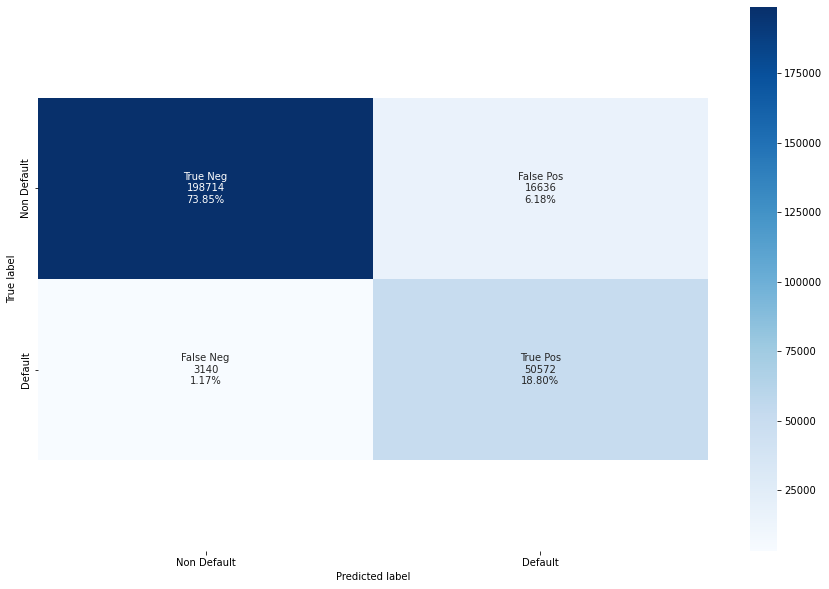

In [51]:
cf = metrics.confusion_matrix(y_test, first_combination_predictions_test)

labels = ['True Neg','False Pos','False Neg','True Pos']

categories = ['Non Default', 'Default']

make_confusion_matrix(cf, group_names=labels,categories=categories, cmap='Blues', figsize = (15,10))

**Dataframe with results for the Positive Class (Predict Default)**

This Dataframe compiles the information of the positive class for the train and test set using the results of both classification reports

In [52]:
resultsDF = performanceMetricsDF(metrics, y_train, first_combination_predictions_train, y_test, first_combination_predictions_test)

resultsDF

,Measure,Train,Test
0,ACCURACY,0.930403,0.926500
1,PRECISION,0.760750,0.752470
2,RECALL,0.950188,0.941540
3,F1 SCORE,0.844982,0.836454


In [68]:
print("The AUC Score for the test is:", roc_auc_score(y_test, stacking_model_first_combination.predict_proba(X_test)[:,1]))

The AUC Score for the test is: 0.9725399808791987


-------

## **Second Combination:** SVM and KNN as level 0 models and LR as the meta classifier

In [53]:
level_0_classifiers_second_combination = dict()
level_0_classifiers_second_combination["SVM"] = pipeline_sgdsvm_rus
level_0_classifiers_second_combination["KNN"] = pipeline_knn_rus

level_1_classifier_second_combination =  SGDClassifier(loss='log',random_state=42,n_jobs=-1,warm_start=True, shuffle = True, class_weight = "balanced", alpha = 0.001)

Fitting the stacking classifier

In [54]:
stacking_model_second_combination = StackingClassifier(estimators=list(level_0_classifiers_second_combination.items()), final_estimator=level_1_classifier_second_combination)

stacking_model_second_combination.fit(X_train, y_train)

StackingClassifier(estimators=[('SVM',
                                Pipeline(steps=[('preprocessor',
                                                 ColumnTransformer(transformers=[('numerical',
                                                                                  Pipeline(steps=[('imputer',
                                                                                                   SimpleImputer(strategy='median')),
                                                                                                  ('scaler',
                                                                                                   StandardScaler())]),
                                                                                  ['loan_amnt',
                                                                                   'term',
                                                                                   'int_rate',
                                              

Predictions on both the training and test set

In [55]:
second_combination_predictions_train = stacking_model_second_combination.predict(X_train)

second_combination_predictions_test =  stacking_model_second_combination.predict(X_test)

**Plot Confusion Matrix**

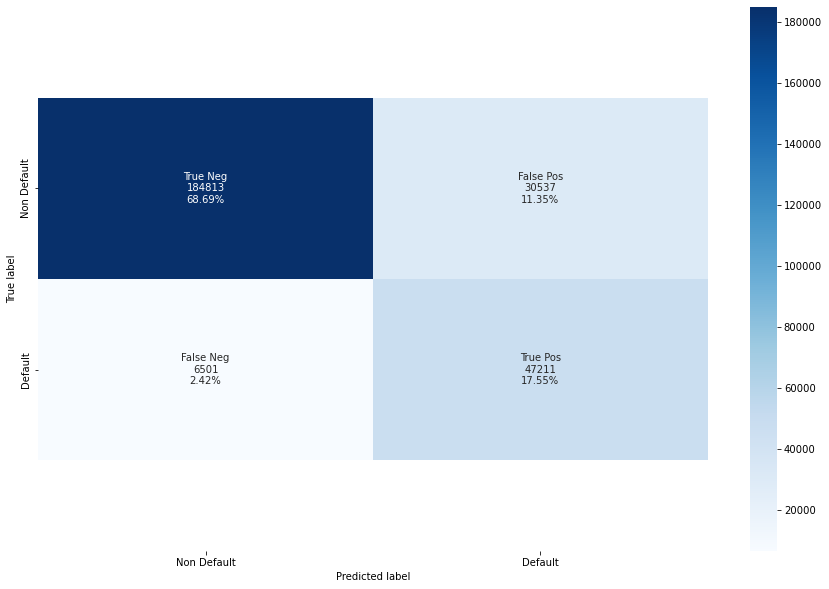

In [56]:
cf = metrics.confusion_matrix(y_test, second_combination_predictions_test)

labels = ['True Neg','False Pos','False Neg','True Pos']

categories = ['Non Default', 'Default']

make_confusion_matrix(cf, group_names=labels,categories=categories, cmap='Blues', figsize = (15,10))

**Dataframe with results for the Positive Class (Predict Default)**

This Dataframe compiles the information of the positive class for the train and test set using the results of both classification reports

In [57]:
resultsDF = performanceMetricsDF(metrics, y_train, second_combination_predictions_train, y_test, second_combination_predictions_test)

resultsDF

,Measure,Train,Test
0,ACCURACY,0.871422,0.862344
1,PRECISION,0.622782,0.607231
2,RECALL,0.902619,0.878966
3,F1 SCORE,0.737032,0.718257


In [70]:
print("The AUC Score for the test is:", roc_auc_score(y_test, stacking_model_second_combination.predict_proba(X_test)[:,1]))

The AUC Score for the test is: 0.9334549134912726


----------------

## **Third Combination:** DT and KNN as level 0 models and LR as the meta classifier

In [58]:
level_0_classifiers_third_combination = dict()
level_0_classifiers_third_combination["DT"] = pipeline_dt
level_0_classifiers_third_combination["KNN"] = pipeline_knn_rus

level_1_classifier_third_combination =  SGDClassifier(loss='log',random_state=42,n_jobs=-1,warm_start=True, shuffle = True, class_weight = "balanced", alpha = 0.001)

Fitting the stacking classifier

In [59]:
stacking_model_third_combination = StackingClassifier(estimators=list(level_0_classifiers_third_combination.items()), final_estimator=level_1_classifier_third_combination, stack)

stacking_model_third_combination.fit(X_train, y_train)

StackingClassifier(estimators=[('DT',
                                Pipeline(steps=[('preprocessor',
                                                 ColumnTransformer(transformers=[('numerical',
                                                                                  Pipeline(steps=[('imputer',
                                                                                                   SimpleImputer(strategy='median'))]),
                                                                                  ['loan_amnt',
                                                                                   'term',
                                                                                   'int_rate',
                                                                                   'annual_inc',
                                                                                   'dti',
                                                                                   'del

Predictions on both the training and test set

In [60]:
third_combination_predictions_train = stacking_model_third_combination.predict(X_train)

third_combination_predictions_test =  stacking_model_third_combination.predict(X_test)

**Plot Confusion Matrix**

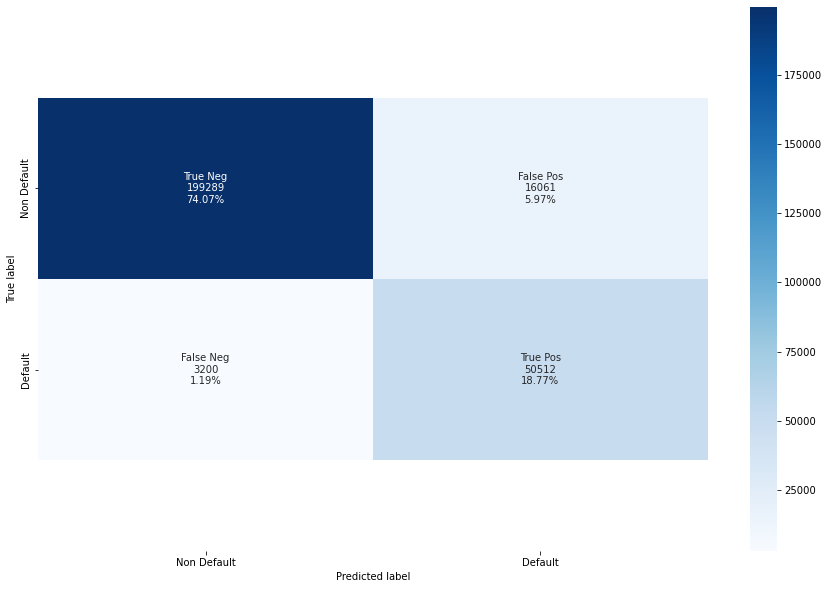

In [61]:
cf = metrics.confusion_matrix(y_test, third_combination_predictions_test)

labels = ['True Neg','False Pos','False Neg','True Pos']

categories = ['Non Default', 'Default']

make_confusion_matrix(cf, group_names=labels,categories=categories, cmap='Blues', figsize = (15,10))

**Dataframe with results for the Positive Class (Predict Default)**

This Dataframe compiles the information of the positive class for the train and test set using the results of both classification reports

In [62]:
resultsDF = performanceMetricsDF(metrics, y_train, third_combination_predictions_train, y_test, third_combination_predictions_test)

resultsDF

,Measure,Train,Test
0,ACCURACY,0.933745,0.928414
1,PRECISION,0.769617,0.758746
2,RECALL,0.953544,0.940423
3,F1 SCORE,0.851765,0.839872


In [71]:
print("The AUC Score for the test is:", roc_auc_score(y_test, stacking_model_third_combination.predict_proba(X_test)[:,1]))

The AUC Score for the test is: 0.9739018783908455


----------

## **Fourth Combination:** DT, SVM and KNN as level 0 models and LR as the meta classifier

In [63]:
level_0_classifiers_fourth_combination = dict()
level_0_classifiers_fourth_combination["SVM"] = pipeline_sgdsvm_rus
level_0_classifiers_fourth_combination["DT"] = pipeline_dt
level_0_classifiers_fourth_combination["KNN"] = pipeline_knn_rus

level_1_classifiers_fourth_combination =  SGDClassifier(loss='log',random_state=42,n_jobs=-1,warm_start=True, shuffle = True, class_weight = "balanced", alpha = 0.001)

Fitting the stacking classifier

In [64]:
stacking_model_fourth_combination = StackingClassifier(estimators=list(level_0_classifiers_fourth_combination.items()), final_estimator=level_1_classifiers_fourth_combination)

stacking_model_fourth_combination.fit(X_train, y_train)

StackingClassifier(estimators=[('SVM',
                                Pipeline(steps=[('preprocessor',
                                                 ColumnTransformer(transformers=[('numerical',
                                                                                  Pipeline(steps=[('imputer',
                                                                                                   SimpleImputer(strategy='median')),
                                                                                                  ('scaler',
                                                                                                   StandardScaler())]),
                                                                                  ['loan_amnt',
                                                                                   'term',
                                                                                   'int_rate',
                                              

Predictions on both the training and test set

In [65]:
fourth_combination_predictions_train = stacking_model_fourth_combination.predict(X_train)

fourth_combination_predictions_test =  stacking_model_fourth_combination.predict(X_test)

**Plot Confusion Matrix**

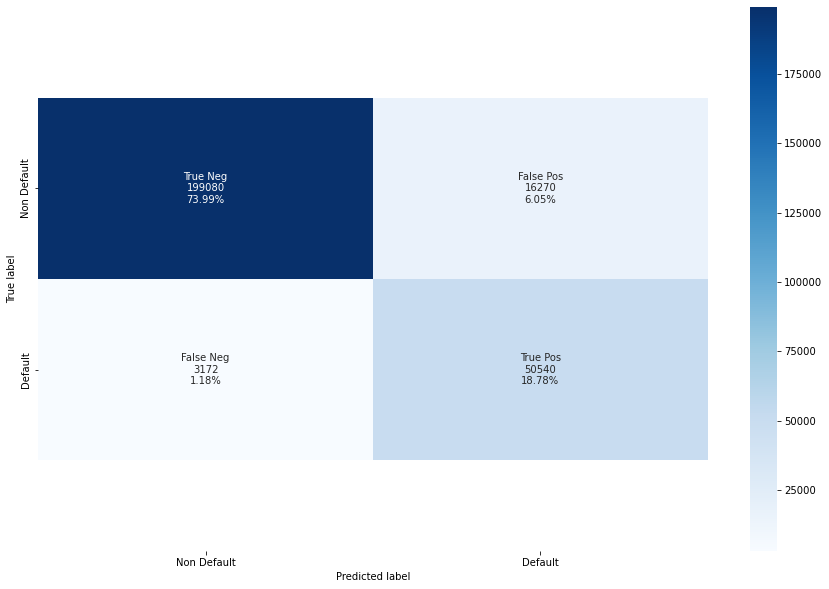

In [66]:
cf = metrics.confusion_matrix(y_test, fourth_combination_predictions_test)

labels = ['True Neg','False Pos','False Neg','True Pos']

categories = ['Non Default', 'Default']

make_confusion_matrix(cf, group_names=labels,categories=categories, cmap='Blues', figsize = (15,10))

**Dataframe with results for the Positive Class (Predict Default)**

This Dataframe compiles the information of the positive class for the train and test set using the results of both classification reports

In [67]:
resultsDF = performanceMetricsDF(metrics, y_train, fourth_combination_predictions_train, y_test, fourth_combination_predictions_test)

resultsDF

,Measure,Train,Test
0,ACCURACY,0.932354,0.927742
1,PRECISION,0.765999,0.756474
2,RECALL,0.951938,0.940944
3,F1 SCORE,0.848906,0.838685


In [72]:
print("The AUC Score for the test is:", roc_auc_score(y_test, stacking_model_fourth_combination.predict_proba(X_test)[:,1]))

The AUC Score for the test is: 0.9730705938383102
